In [1]:
from Bio import SeqIO
%load_ext rpy2.ipython
%R library(dplyr); library(magrittr); library(ggplot2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<StrVector - Python:0x10ae62dd0 / R:0x107e15898>
[str, str, str, ..., str, str, str]

In [2]:
info=open("syn_vib_myco_phage_info.txt").readlines()
info[0]

'phage_full\tphage_short\ttax\tsize\tgc\thost_genus\ttrna_count\ttrna_check\n'

In [3]:
myos=[]

for l in info[1:]:
    if l.split("\t")[2]=="Myoviridae":
        myos.append(l.split("\t")[0])


Searching for major capsid proteins to examine myovirus phylogeny within this collection and with which to compare tRNA content to:

In [18]:
import re
count=0

to_blast=[]
maj=open("majcapprot.faa","w")
nowcaps=[]

for n in myos:
    gbk=SeqIO.parse("./pgenomes/"+n+".gbk", "genbank")
    capsid="no"
    for rec in gbk:
        for feature in rec.features:
            if feature.type=="CDS" and re.search('major capsid protein', feature.qualifiers["product"][0]):
                count+=1
                #maj.write(">"+n+"_"+feature.qualifiers["product"][0]+"\n"+feature.qualifiers["translation"][0]+"\n")
                maj.write(">"+n+"\n"+feature.qualifiers["translation"][0]+"\n")
                capsid="yes"
                nowcaps.append(n)
    if capsid=="no":
        out=open("./pgenomes/"+n+".faa","w")
        to_blast.append(n)
        for feature in rec.features:
            if feature.type=="CDS":
                out.write(">"+n+"_"+feature.qualifiers["protein_id"][0]+"\n"+feature.qualifiers["translation"][0]+"\n")
        out.close()
maj.close()           
print(str(count)+" out of "+str(len(myos))+" have major capsid proteins")

20 out of 75 have major capsid proteins


In [19]:
!scp majcapprot.faa jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/

majcapprot.faa                                100% 8081     7.9KB/s   00:00    


For genomes that do not have 

In [22]:
out=open("majcapblast.sh","w")

out.write("#!/bin/bash\n#SBATCH -n 16\n#SBATCH -N 1\n#SBATCH -o db.out\n#SBATCH -e db.err\n#SBATCH -p sched_mit_chisholm\n\n")

out.write("module add engaging/ncbi-blast/2.2.30+\n\n")
                                                                                        
out.write("makeblastdb -in majcapprot.faa -dbtype prot\n\n")

for n in to_blast:

    out.write("blastp -db majcapprot.faa -query "+n+".faa -outfmt 6 -num_descriptions 1 ")
    out.write("-evalue 0.001 -out "+n+"vs.majcapprot.out\n")


out.close()
!open majcapblast.sh -a textedit
!scp majcapblast.sh jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/

majcapblast.sh                                100% 7106     6.9KB/s   00:00    


In [21]:
!scp ./pgenomes/*faa jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/

AB374228.1.faa                                100%   12KB  11.8KB/s   00:00    
AY129337.1.faa                                100%   51KB  51.1KB/s   00:00    
DQ149023.2.faa                                100%   62KB  61.7KB/s   00:00    
DQ398053.1.faa                                100%   50KB  50.2KB/s   00:00    
EU826466.1.faa                                100%   55KB  55.0KB/s   00:00    
EU826467.1.faa                                100%   51KB  50.9KB/s   00:00    
EU826468.1.faa                                100%   51KB  51.1KB/s   00:00    
EU826469.1.faa                                100%   51KB  50.6KB/s   00:00    
EU826471.1.faa                                100%   51KB  51.3KB/s   00:00    
FN297812.1.faa                                100%   14KB  14.2KB/s   00:00    
GQ303260.1.faa                                100%   51KB  51.3KB/s   00:00    
GQ303262.1.faa                                100%   51KB  51.4KB/s   00:00    
HG803181.1.faa                          

In [106]:
!muscle -in majcapprot.faa -out majcapprot.aln.faa


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

majcapprot 20 seqs, max length 514, avg  length 390
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      7 MB(0%)  Iter   1  100.00%  Align node
00:00:00      7 MB(0%)  Iter   1  100.00%  Root alignment
00:00:00      8 MB(0%)  Iter   2  100.00%  Refine tree
00:00:00      8 MB(0%)  Iter   2  100.00%  Root alignment
00:00:00      8 MB(0%)  Iter   2  100.00%  Root alignment
00:00:00      8 MB(0%)  Iter   3  100.00%  Refine biparts
00:00:00      8 MB(0%)  Iter   4  100.00%  Refine biparts
00:00:00      8 MB(0%)  Iter   5  100.00%  Refine biparts
00:00:00      8 MB(0%)  Iter   5  100.00%  Refine biparts
00:00:00      8 MB(0%)  Iter   6  100.00%  Refine biparts
00:00:00      8 MB(0%)  Iter   7  100.00%  Refine biparts
00:00:00      8 MB(0%) 

In [21]:
from skbio.alignment import Alignment
from skbio.sequence import DNA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itolapi import Itol, ItolExport
from IPython.display import Image
%matplotlib inline

aln=Alignment.read(file="majcapprot.aln.faa", format="fasta")
gap_freq=[d["-"] for d in aln.position_frequencies()]
len(gap_freq)
fig, ax = plt.subplots()
fig.set_size_inches([16,3])
ax.plot(np.arange(len(gap_freq)), gap_freq)
ax.set_xlabel("Position")
ax.set_ylabel("Gap frequency")

gap_thresh=0
keepers, = np.where(np.array(gap_freq)<=gap_thresh)
aln_masked = aln.subalignment(positions_to_keep=keepers)
gap_freq2=[d["-"] for d in aln_masked.position_frequencies()]
print(len(gap_freq2))
aln_masked.write("majcapprot.aln.nogap.faa")


194


'majcapprot.aln.nogap.faa'

In [ ]:
!fasttree <majcapprot.aln.nogap.faa> majcapprot.aln.nogap.tree

In [16]:
from random import randint
colors = []

for i in range(10):
    colors.append('%06X' % randint(0, 0xFFFFFF))
print(colors)


out1=open("tree1.trna.count.txt","w")
#out2=open("tree1.host_cols.txt","w")
print info[0]
for line in info:
    vec=line.split("\t")
    if vec[0] in nowcaps:
        out1.write(vec[0]+","+vec[6]+"\n")
        print(vec[0]+","+vec[5])
out1.close()

['3B6871', '984CEB', 'D924A4', '34467A', '7D3B42', '420055', 'D67F30', 'A51E18', 'AB39B6', '688D61']
phage_full	phage_short	tax	size	gc	host_genus	trna_count	trna_check

NC_020845.1,Syn/Pro
NC_019516.1,Syn/Pro
NC_013085.1,Syn/Pro
NC_015569.1,Syn/Pro
FM207411.1,Syn/Pro
NC_008296.2,Syn/Pro
NC_020836.1,Syn/Pro
KJ572844.2,Vibrio
NC_005083.2,Vibrio
NC_019518.1,Vibrio
NC_019457.1,Vibrio
NC_023568.1,Vibrio
AB374228.1,Vibrio
KC691257.1,Mycobacterium
KC748968.1,Mycobacterium
KC748970.1,Mycobacterium
KF024734.1,Mycobacterium
KM881426.1,Mycobacterium
KR080196.1,Mycobacterium
KT321476.1,Mycobacterium


In [104]:
from random import randint
colors = []

for i in range(10):
    colors.append('%06X' % randint(0, 0xFFFFFF))
print(colors)

['83B5CA', 'B4506E', '277E38', 'A23AD2', '265518', 'A456C5', '7352B1', 'FB778B', '50938F', '349E67']


In [23]:
itol_uploader = Itol.Itol()
itol_uploader.add_variable('treeFile', 'majcapprot.aln.nogap.tree')
itol_uploader.add_variable('treeFormat', 'newick')
itol_uploader.add_variable('treeName', 'ours and theirs with taxa colors')
itol_uploader.add_variable("dataset1File","tree1.trna.count.txt")
itol_uploader.add_variable("dataset1Type", "simplebar")
itol_uploader.add_variable("dataset1Label", "tRNA_count")
itol_uploader.add_variable("dataset1Separator","comma")
itol_uploader.add_variable("dataset1Color","#160EF2")

status = itol_uploader.upload()
itol_uploader.comm.upload_output
print itol_uploader.get_webpage()


http://itol.embl.de/external.cgi?tree=129981071282311814406414760&restore_saved=1


20 out of 75 have major capsid proteins


In [12]:
for phage in myos:
    gbk=SeqIO.parse("./pgenomes/"+phage+".gbk", "genbank")
    for rec in gbk:
        if 'comment' in rec.annotations.keys():
            continue
        else:
            print(rec.annotations)

{'sequence_version': 1, 'source': 'Synechococcus phage S-RSM4', 'taxonomy': ['Viruses', 'dsDNA viruses, no RNA stage', 'Caudovirales', 'Myoviridae', 'Tevenvirinae', 'T4likevirus'], 'keywords': ['complete genome'], 'references': [Reference(title='Comparative genomics of marine cyanomyoviruses reveals the widespread occurrence of Synechococcus host genes localized to a hyperplastic region: implications for mechanisms of cyanophage evolution', ...), Reference(title='Direct Submission', ...)], 'accessions': ['FM207411'], 'data_file_division': 'PHG', 'date': '22-SEP-2009', 'organism': 'Synechococcus phage S-RSM4', 'gi': '255705208'}
{'sequence_version': 1, 'source': 'Vibrio phage ICP1_2004_A', 'taxonomy': ['Viruses', 'dsDNA viruses, no RNA stage', 'Caudovirales', 'Myoviridae'], 'keywords': [''], 'references': [Reference(title='Evidence of a dominant lineage of Vibrio cholerae-specific lytic bacteriophages shed by cholera patients over a 10-year period in Dhaka, Bangladesh', ...), Reference(

In [23]:
!scp jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/*vs.majcapprot.out ./

AY129337.1vs.majcapprot.out                   100%  490     0.5KB/s   00:01    
DQ149023.2vs.majcapprot.out                   100%  720     0.7KB/s   00:00    
DQ398053.1vs.majcapprot.out                   100%  490     0.5KB/s   00:00    
EU826466.1vs.majcapprot.out                   100%  490     0.5KB/s   00:00    
EU826467.1vs.majcapprot.out                   100%  490     0.5KB/s   00:01    
EU826468.1vs.majcapprot.out                   100%  490     0.5KB/s   00:00    
EU826469.1vs.majcapprot.out                   100%  483     0.5KB/s   00:00    
EU826471.1vs.majcapprot.out                   100%  490     0.2KB/s   00:02    
FN297812.1vs.majcapprot.out                   100%  149     0.2KB/s   00:00    
GQ303260.1vs.majcapprot.out                   100%  490     0.5KB/s   00:00    
GQ303262.1vs.majcapprot.out                   100%  490     0.5KB/s   00:00    
HG803181.1vs.majcapprot.out                   100%    0     0.0KB/s   00:00    
HQ317393.2vs.majcapprot.out             

In [24]:
from pyfaidx import Fasta
import os
import sys
import os.path


phages=to_blast
output_name="myo.gp23.faa"
blast_suffix="vs.majcapprot.out"

outfast=open(output_name,"w")

for phage in phages:
	best_evalue=1
	if os.path.exists(phage+blast_suffix) and len(open(phage+blast_suffix).readlines())>0:
		blast=open(phage+blast_suffix).readlines()
		for line in blast:    
			if float(line.split("\t")[10])<best_evalue:
				best_evalue=float(line.split("\t")[10])
				terminase=line.split("\t")[0]
		print(terminase)
		f=Fasta("./pgenomes/"+phage+".faa")
		a = str(f[terminase])
		outfast.write(">"+phage+"\n"+a+"\n")
	else:
		print("blast file for "+phage+" does not exist")

outfast.close()

DQ149023.2_ABA47103.1
NC_015289.1_YP_004324729.1
NC_015287.1_YP_004324201.1
NC_015286.1_YP_004323954.1
NC_015282.1_YP_004323024.1
NC_015281.1_YP_004322790.1
NC_015279.1_YP_004322275.1
NC_006820.1_YP_195142.1
NC_020875.1_YP_007677276.1
blast file for NC_020847.1 does not exist
NC_021071.1_YP_007877734.1
NC_020855.1_YP_007675133.1
NC_019722.1_YP_007112491.1
blast file for NC_015157.1 does not exist
blast file for KJ545483.2 does not exist
HQ317393.2_AGN30034.1
blast file for NC_024369.2 does not exist
NC_022747.1_YP_008766839.1
NC_003313.1_NP_536650.1
NC_010275.1_YP_001650889.1
blast file for NC_004456.1 does not exist
blast file for NC_027368.1 does not exist
blast file for NC_009016.1 does not exist
blast file for HQ641354.1 does not exist
blast file for HQ641353.1 does not exist
blast file for HQ641352.1 does not exist
blast file for HQ641351.1 does not exist
blast file for HQ641350.1 does not exist
blast file for HQ641349.1 does not exist
blast file for HQ641348.1 does not exist
blas

In [25]:
!cat myo.gp23.faa majcapprot.faa > myo_capsid_proteins.faa

In [26]:
!head myo_capsid_proteins.faa

>DQ149023.2
MSFQNLQEKWAPVLEHDSLPEIGDSYKKGVVAQLLENQEKAIAEEGKILTETLQTTGYTGGDTVTGPVAGFDPVLISLIRRSMPQLIAYDIAGVQPMTGPTGLIFAMRTNYGAERNPAAAGYDEAFFNEPNAGFSGGPGAYDPGATGVTNDAEGTNPALLNDSPAGTYEQADDATGMSTATVEALDDSTANTAFREMGFSIEKVTVTARARALKAEYSIEMAQDLKAIHGLDAEQELANILSTEILAEINREVVRTIYTNAVAGAQNNTATAGVFDLDVDSNGRWSVEKFKGLLFQIERDANAIGHQTRRGKGNILICSADVVSALGMAGVLDYTPALNGNNGLAGVDDTSSTLVGTLNGRIKVYVDPYSANVADKHFYVAGYKGTSPYDAGLFYCPYVPLQQVRAINPDTFQPKIGFKTRYGMVSNPFAGGLTQGSGALTVNANKYYRRVQVANLM
>NC_015289.1
MSLNQLQEKWAPVLNHDSLPEIEDSHKRGVVAQLLENQEKALVEEGQILSETLQTAGTGGFGGGATATGPVAGFDPVLISLIRRSMPQLIAYDIAGVQPMTGPTGLIFAMRTQYGTERDPSSSDYREAFFNEPNAGFSGADGNRLADYDPTASSSAINDAEGANPGLLNDSPAGTYELTGDAQGMNTTALEAITDAAAATAFREMGFSIEKVTVTAKARALKAEYSIELAQDLKAIHGLDAEQELANILSTEILAEINREVVRTIYTNAVAGAQNNTANAGIFDLDVDSNGRWSVEKFKGLLFQIERDANAIGHQTRRGKGNILIASADVVSALGMAGVLDYAPALQGNNGLVPDDNSSTLVGTLNGRIKVYVDPYSANVADKHYYVAGYKGTSPYDAGLFYCPYVPLQQVRAINPDTFQPKIGFKTRYGMVSNPFAQGLTQGSGALTANTNKYYRRVQVANLM
>NC_015287.1
MQQNINYQQLTEKWAPLLDHEGSDPIKDAHRRNVTAVLL

In [38]:
f=Fasta("myo_capsid_proteins.faa")
len(f.keys())
phages=f.keys()

In [30]:
!muscle -in myo_capsid_proteins.faa -out myo_capsid_proteins.aln.faa


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

myo_capsid_proteins 59 seqs, max length 516, avg  length 376
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     16 MB(0%)  Iter   1  100.00%  Align node
00:00:00     16 MB(0%)  Iter   1  100.00%  Root alignment
00:00:00     17 MB(0%)  Iter   2  100.00%  Refine tree
00:00:00     17 MB(0%)  Iter   2  100.00%  Root alignment
00:00:00     17 MB(0%)  Iter   2  100.00%  Root alignment
00:00:00     17 MB(0%)  Iter   3  100.00%  Refine biparts
00:00:01     17 MB(0%)  Iter   4  100.00%  Refine biparts
00:00:01     17 MB(0%)  Iter   5  100.00%  Refine biparts
00:00:01     17 MB(0%)  Iter   6  100.00%  Refine biparts
00:00:01     17 MB(0%)  Iter   6  100.00%  Refine biparts
00:00:01     17 MB(0%)  Iter   7  100.00%  Refine biparts
00:00:02     1

325


'myo_capsid_proteins.aln.2gap.faa'

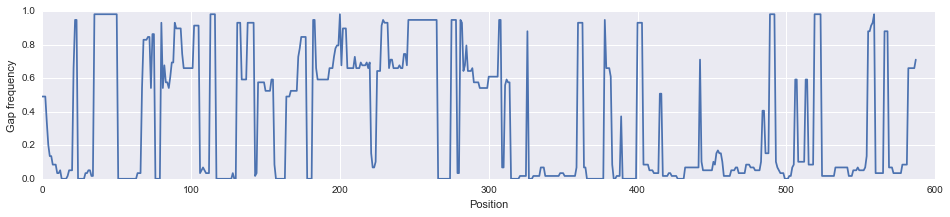

In [34]:
from skbio.alignment import Alignment
from skbio.sequence import DNA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itolapi import Itol, ItolExport
from IPython.display import Image
%matplotlib inline

aln=Alignment.read(file="myo_capsid_proteins.aln.faa", format="fasta")
gap_freq=[d["-"] for d in aln.position_frequencies()]
len(gap_freq)
fig, ax = plt.subplots()
fig.set_size_inches([16,3])
ax.plot(np.arange(len(gap_freq)), gap_freq)
ax.set_xlabel("Position")
ax.set_ylabel("Gap frequency")

gap_thresh=0.2
keepers, = np.where(np.array(gap_freq)<=gap_thresh)
aln_masked = aln.subalignment(positions_to_keep=keepers)
gap_freq2=[d["-"] for d in aln_masked.position_frequencies()]
print(len(gap_freq2))
aln_masked.write("myo_capsid_proteins.aln.2gap.faa")


In [35]:
!fasttree <myo_capsid_proteins.aln.2gap.faa> myo_capsid_proteins.aln.2gap.tree

FastTree Version 2.1.8 No SSE3
Alignment: standard input
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Initial topology in 0.01 seconds
Refining topology: 20 rounds ME-NNIs, 2 rounds ME-SPRs, 10 rounds ML-NNIs
Total branch-length 9.501 after 0.13 sec
ML-NNI round 1: LogLk = -9282.919 NNIs 6 max delta 5.84 Time 0.43
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 0.905 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -9005.604 NNIs 1 max delta 0.06 Time 0.73
Turning off heuristics for final round of ML NNIs (converged)
ML-NNI round 3: LogLk = -9004.814 NNIs 2 max delta 0.24 Time 0.98 (final)
Optimize all lengths: L

In [37]:
itol_uploader = Itol.Itol()
itol_uploader.add_variable('treeFile', 'myo_capsid_proteins.aln.2gap.tree')
itol_uploader.add_variable('treeFormat', 'newick')
itol_uploader.add_variable('treeName', 'ours and theirs with taxa colors')
#itol_uploader.add_variable("dataset1File","tree1.trna.count.txt")
#itol_uploader.add_variable("dataset1Type", "simplebar")
#itol_uploader.add_variable("dataset1Label", "tRNA_count")
#itol_uploader.add_variable("dataset1Separator","comma")
#itol_uploader.add_variable("dataset1Color","#160EF2")

status = itol_uploader.upload()
itol_uploader.comm.upload_output
print itol_uploader.get_webpage()

http://itol.embl.de/external.cgi?tree=129981071284327514406902810&restore_saved=1


In [40]:
from random import randint
colors = []

for i in range(10):
    colors.append('%06X' % randint(0, 0xFFFFFF))
print(colors)


out1=open("tree2.trna.count.txt","w")
out2=open("tree2.host_cols.txt","w")
print info[0]
for line in info:
    vec=line.split("\t")
    if vec[0] in phages:
        out1.write(vec[0]+","+vec[6]+"\n")
        if vec[5]=="Mycobacterium":
            col="#FA5858"
        elif vec[5]=="Syn/Pro":
            col="#04B404"
        else:
            col="#0174DF"
        out2.write(vec[0]+"\t"+"range"+"\t"+col+"\t"+vec[5]+"\n")
out1.close()
out2.close()

['C09F40', 'F0B396', '907FC8', '3BCD20', '9A5CE1', '877BB0', '979476', '5EB8FB', '59BCEC', 'F43225']
phage_full	phage_short	tax	size	gc	host_genus	trna_count	trna_check



In [41]:
itol_uploader = Itol.Itol()
itol_uploader.add_variable('treeFile', 'myo_capsid_proteins.aln.2gap.tree')
itol_uploader.add_variable('treeFormat', 'newick')
itol_uploader.add_variable('treeName', 'ours and theirs with taxa colors')
itol_uploader.add_variable("dataset1File","tree2.trna.count.txt")
itol_uploader.add_variable("dataset1Type", "simplebar")
itol_uploader.add_variable("dataset1Label", "tRNA_count")
itol_uploader.add_variable("dataset1Separator","comma")
itol_uploader.add_variable("dataset1Color","#160EF2")

itol_uploader.add_variable("colorDefinitionFile","tree2.host_cols.txt")

status = itol_uploader.upload()
itol_uploader.comm.upload_output
print itol_uploader.get_webpage()

http://itol.embl.de/external.cgi?tree=129981071284674914406909790&restore_saved=1


In [45]:
from itolapi import ItolExport
itol_exporter = ItolExport.ItolExport()
itol_exporter.set_export_param_value("tree", itol_uploader.comm.tree_id)
itol_exporter.set_export_param_value("format", "png")
itol_exporter.set_export_param_value("displayMode", "normal")
itol_exporter.set_export_param_value("datasetList","dataset1")
itol_exporter.set_export_param_value("rangesCover","clades")
itol_exporter.export("tree2.png")

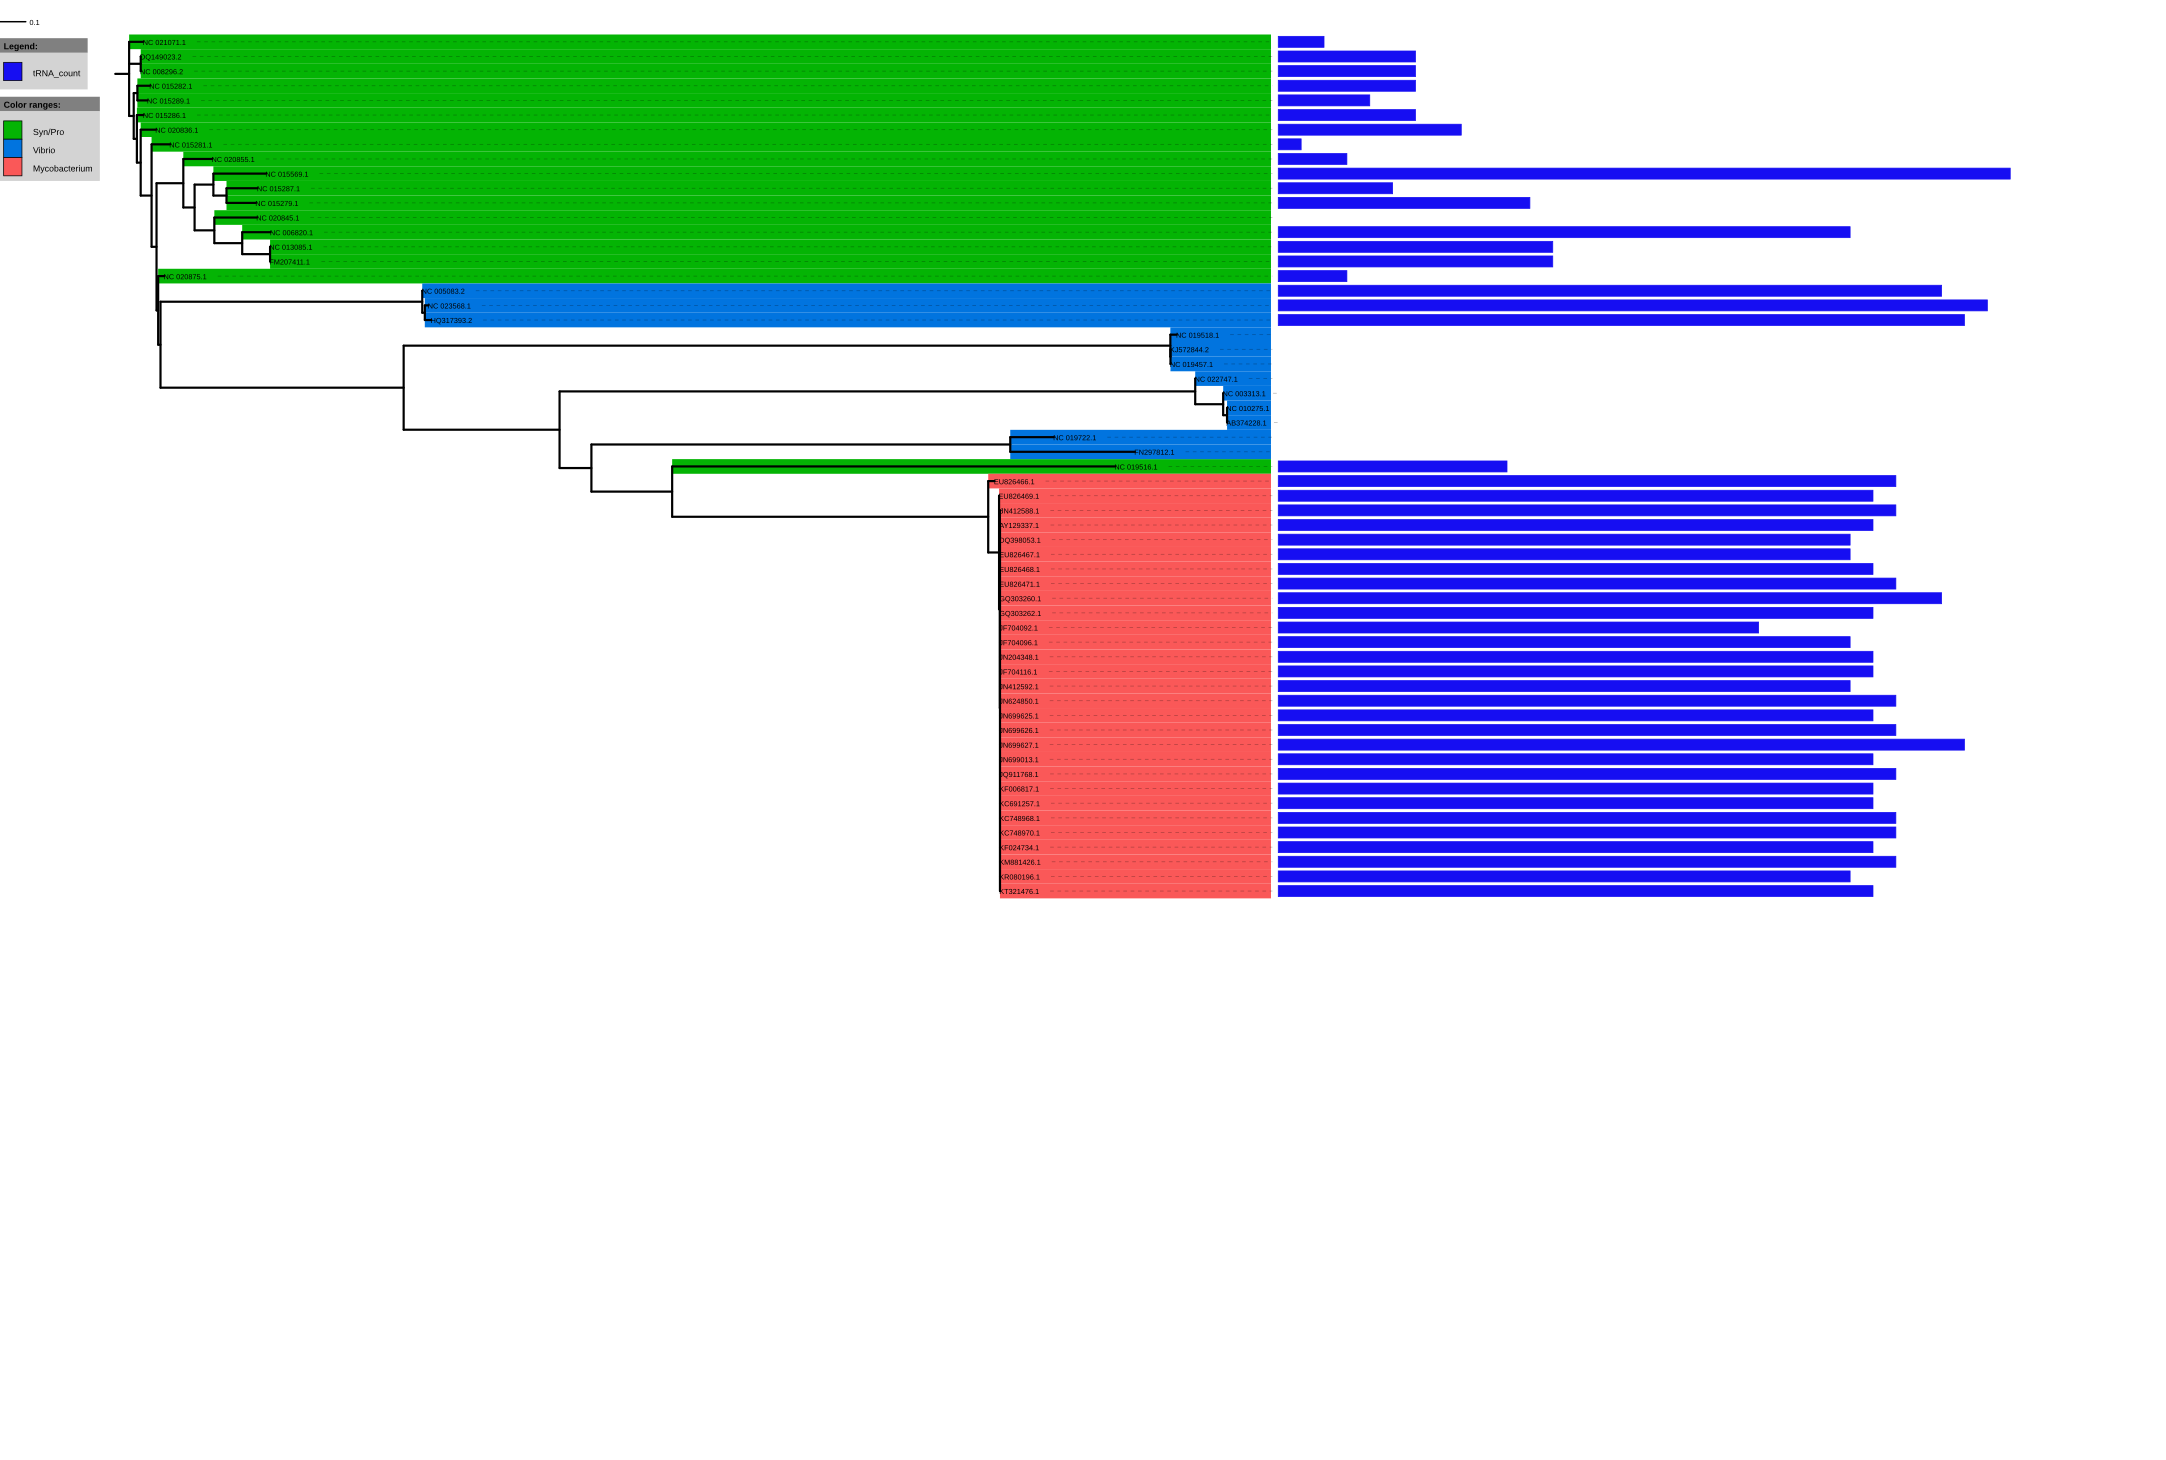

In [46]:
Image("tree2.png",width=600)